<a href="https://colab.research.google.com/github/MRifdaM/Capstone_Halal-Nutrition-Risk_IBM-x-Hacktive8/blob/main/Capstone_Halal_%26_Nutrition_Risk_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1.1. Instalasi library yang dibutuhkan
# tqdm untuk progress bar, datasets & pyarrow untuk penanganan data, replicate untuk API
!pip install replicate tqdm datasets pyarrow -q

In [ ]:

# 1.2. Impor semua library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import replicate
import os
import time
from datasets import load_dataset
from tqdm.notebook import tqdm
from google.colab import userdata
import warnings

warnings.filterwarnings('ignore')

# 1.3. Konfigurasi API Key Replicate dengan nama secret 'api_token'
try:
    # Menggunakan nama 'api_token' sesuai gambar yang Anda berikan
    REPLICATE_API_TOKEN = userdata.get('api_token')
    os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
    print("✅ API Token Replicate berhasil dikonfigurasi dengan secret 'api_token'.")
except userdata.SecretNotFoundError:
    print("❌ ERROR: Secret 'api_token' tidak ditemukan. Mohon periksa kembali namanya di panel Secrets.")
except Exception as e:
    print(f"❌ Terjadi error: {e}")

✅ API Token Replicate berhasil dikonfigurasi dengan secret 'api_token'.


In [ ]:
# 2.1. Tentukan jumlah baris yang ingin diambil
num_rows_to_take = 50000
output_filename = 'openfoodfacts_sample.csv'

print(f"Mempersiapkan untuk streaming dan mengambil {num_rows_to_take} baris data...")

# 2.2. Muat dataset dalam mode streaming
streamed_dataset = load_dataset("openfoodfacts/product-database", streaming=True, split="food")

# 2.3. Siapkan list kosong untuk menampung data
records = []

# 2.4. Loop melalui dataset dan berhenti setelah mencapai batas
for i, row in enumerate(tqdm(streamed_dataset, total=num_rows_to_take, desc="📥 Mengambil Sampel")):
    if i >= num_rows_to_take:
        break
    records.append(row)

print(f"\n✅ Selesai! Berhasil mengambil {len(records)} baris data.")

# 2.5. Konversi dan simpan sampel data ke file CSV lokal
if records:
    df_sample = pd.DataFrame(records)
    df_sample.to_csv(output_filename, index=False)
    print(f"🎉 Berhasil! Sampel data telah disimpan ke file '{output_filename}'.")
else:
    print("\n⚠️ Tidak ada data yang berhasil diambil.")

Mempersiapkan untuk streaming dan mengambil 50000 baris data...


📥 Mengambil Sampel:   0%|          | 0/50000 [00:00<?, ?it/s]


✅ Selesai! Berhasil mengambil 50000 baris data.
🎉 Berhasil! Sampel data telah disimpan ke file 'openfoodfacts_sample.csv'.


In [ ]:
import pandas as pd
import ast

# --- LANGKAH 3 (REVISI FINAL) ---

# 3.1. Muat dan siapkan data seperti sebelumnya
output_filename = 'openfoodfacts_sample.csv'
df = pd.read_csv(output_filename)
relevant_columns = ['code', 'product_name', 'brands', 'categories', 'ingredients_text', 'nutriments']
df_clean = df[relevant_columns].copy()
df_clean.dropna(subset=['ingredients_text', 'categories', 'nutriments'], inplace=True)
print(f"✅ Data awal siap: {len(df_clean)} produk.")

# --- FUNGSI EKSTRAKSI BARU ---
print("\nMendefinisikan fungsi ekstraksi baru untuk struktur data list...")

def extract_nutrient_from_list(nutriments_list, target_names):
    """
    Fungsi ini akan mencari di dalam list of dictionaries.
    Ia mencari dictionary di mana 'name' cocok dengan salah satu target_names,
    lalu mengembalikan nilai dari key '100g'.
    """
    # Pastikan inputnya adalah list
    if not isinstance(nutriments_list, list):
        return None

    # Loop melalui setiap dictionary di dalam list
    for nutrient_dict in nutriments_list:
        # Pastikan itemnya adalah dictionary dan punya key 'name'
        if isinstance(nutrient_dict, dict) and 'name' in nutrient_dict:
            # Jika nama nutrisi cocok dengan yang kita cari
            if str(nutrient_dict['name']).lower() in target_names:
                # Kembalikan nilainya, utamakan '100g'
                if '100g' in nutrient_dict:
                    return nutrient_dict['100g']
                elif 'value' in nutrient_dict: # Fallback ke 'value' jika '100g' tidak ada
                    return nutrient_dict['value']

    # Jika tidak ditemukan setelah loop selesai
    return None

# --- APLIKASIKAN FUNGSI EKSTRAKSI ---
print("Mengekstrak data nutrisi dengan fungsi baru...")

# Ubah kolom 'nutriments' dari string menjadi objek Python (list)
# Ini adalah langkah yang paling intensif secara komputasi
nutriments_series = df_clean['nutriments'].apply(ast.literal_eval)

# Terapkan fungsi untuk setiap nutrisi yang kita inginkan
df_clean['sugars_100g'] = nutriments_series.apply(
    lambda x: extract_nutrient_from_list(x, ['sugars', 'sugars_100g'])
)
df_clean['saturated-fat_100g'] = nutriments_series.apply(
    lambda x: extract_nutrient_from_list(x, ['saturated-fat', 'saturated-fat_100g'])
)
df_clean['salt_100g'] = nutriments_series.apply(
    lambda x: extract_nutrient_from_list(x, ['salt', 'salt_100g'])
)
# Ekstrak sodium sebagai fallback untuk salt
df_clean['sodium_100g'] = nutriments_series.apply(
    lambda x: extract_nutrient_from_list(x, ['sodium', 'sodium_100g'])
)

# Jika salt masih kosong, hitung dari sodium
df_clean['salt_100g'].fillna(df_clean['sodium_100g'] * 2.5, inplace=True)
print("✅ Ekstraksi selesai.")

# --- FINALISASI DAN PEMBERSIHAN (REVISI) ---

# Hapus kolom yang tidak dipakai lagi
df_clean.drop(columns=['nutriments', 'sodium_100g'], inplace=True, errors='ignore')

# Konversi kolom nutrisi ke numerik (tanpa fillna(0))
nut_cols = ['sugars_100g', 'salt_100g', 'saturated-fat_100g']
for col in nut_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Sanity check: nilai negatif tidak valid → NaN
for col in nut_cols:
    df_clean.loc[df_clean[col] < 0, col] = pd.NA

# Pembersihan kolom teks
df_clean['ingredients_text'] = df_clean['ingredients_text'].astype(str).str.lower()

# (Opsional) kategori utama pakai token terakhir agar lebih spesifik
df_clean['categories_main'] = (
    df_clean['categories'].astype(str)
    .apply(lambda s: [c.strip() for c in s.split(',') if c.strip()])
    .apply(lambda parts: parts[-1].lower() if parts else pd.NA)
)

# --- LAPORAN COVERAGE JUJUR (tanpa mengganti NaN jadi 0) ---
def coverage(col):
    return (df_clean[col].notna().mean() * 100).round(1)

print("\n[HASIL] Coverage nutrien (jujur, tanpa imputasi):")
print(f"  sugars_100g        : {coverage('sugars_100g')}% ({df_clean['sugars_100g'].notna().sum()} baris)")
print(f"  salt_100g          : {coverage('salt_100g')}% ({df_clean['salt_100g'].notna().sum()} baris)")
print(f"  saturated-fat_100g : {coverage('saturated-fat_100g')}% ({df_clean['saturated-fat_100g'].notna().sum()} baris)")

# (Opsional) ringkasan cepat nilai yang ada
print("\nDeskriptif (hanya baris yang punya data):")
print(df_clean[nut_cols].describe())
print(f"\n✅ Data siap dianalisis: {len(df_clean)} produk.")

print(f"\n✅ Data siap dianalisis: {len(df_clean)} produk.")

✅ Data awal siap: 45519 produk.

Mendefinisikan fungsi ekstraksi baru untuk struktur data list...
Mengekstrak data nutrisi dengan fungsi baru...
✅ Ekstraksi selesai.

[HASIL] Coverage nutrien (jujur, tanpa imputasi):
  sugars_100g        : 91.1% (41490 baris)
  salt_100g          : 94.8% (43130 baris)
  saturated-fat_100g : 84.3% (38376 baris)

Deskriptif (hanya baris yang punya data):
        sugars_100g     salt_100g  saturated-fat_100g
count  41490.000000  43130.000000        38376.000000
mean      33.823408      0.805047           10.813572
std       82.840608     17.032231           29.531239
min        0.000000      0.000000            0.000000
25%        1.390000      0.000292            0.000000
50%        7.100000      0.004965            1.220000
75%       30.000000      0.362500           10.000000
max     1670.000000   3250.000000          663.000000

✅ Data siap dianalisis: 45519 produk.

✅ Data siap dianalisis: 45519 produk.


In [ ]:
df_clean.head(100)

,code,product_name,brands,categories,ingredients_text,sugars_100g,saturated-fat_100g,salt_100g,categories_main
0,101209159,"[{'lang': 'main', 'text': 'Véritable pâte à ta...",Bovetti,"Petit-déjeuners,Produits à tartiner,Produits à...",[],32.000000,10.000000,0.0100,pâtes à tartiner aux noisettes et au cacao
2,105000042,"[{'lang': 'main', 'text': ""Lagg's, herbal tea,...",Lagg's,"Plant-based foods and beverages, Beverages, Ho...","[{'lang': 'main', 'text': 'peppermint.'}, {'la...",NaN,NaN,0.0100,tea bags
3,105000059,"[{'lang': 'main', 'text': 'Linden Flowers Tea'...",Lagg's,"Beverages and beverages preparations, Plant-ba...","[{'lang': 'main', 'text': 'linden flowers.'}, ...",NaN,NaN,NaN,en:tea-bags
8,105000356,"[{'lang': 'main', 'text': ""Lagg's, herbal tea,...",Lagg's,"Plant-based foods and beverages, Beverages, Ho...","[{'lang': 'main', 'text': 'chamomile spearmint...",NaN,NaN,0.0000,tea bags
10,105000417,"[{'lang': 'main', 'text': ""Lagg's, dieter's he...",Lagg's,"Plant-based foods and beverages, Beverages, Ho...","[{'lang': 'main', 'text': 'andropogon citratus...",NaN,NaN,0.0000,tea bags
...,...,...,...,...,...,...,...,...,...
170,835766355,"[{'lang': 'main', 'text': 'Creamed honey with ...","Vintage, Vintage Bee","Breakfasts, Spreads, Sweet spreads, Bee produc...","[{'lang': 'main', 'text': 'pure raw honey, lem...",76.190002,0.000000,0.0000,honeys
175,835766607,"[{'lang': 'main', 'text': 'Vintage minis'}, {'...","Vintage, Vintage Bee Inc.","Breakfasts, Spreads, Sweet spreads, Bee produc...","[{'lang': 'main', 'text': 'pure raw honey, rea...",80.000000,NaN,0.0000,honeys
181,901005005,"[{'lang': 'main', 'text': 'Guiltless Gourmet, ...",Guiltless Gourmet Inc.,"Plant-based foods and beverages, Beverages, Pl...","[{'lang': 'main', 'text': 'organic coconut wat...",3.000000,0.000000,0.0275,plant-based beverages
184,946909078,"[{'lang': 'main', 'text': 'Augason Farms, Vita...",Blue Chip Group,"Plant-based foods and beverages, Plant-based f...","[{'lang': 'main', 'text': 'vital wheat gluten....",0.000000,0.000000,0.0000,cereals and their products


In [ ]:
# 3.1. Definisikan fungsi klasifikasi batch
def classify_ingredients_batch(ingredients_list):
    numbered_ingredients = ""
    for i, text in enumerate(ingredients_list):
        clean_text = str(text).replace('"', "'").replace('\n', ' ')
        numbered_ingredients += f"{i+1}. \"{clean_text}\"\n"

    prompt = f"""
    You are an expert AI food analyst. Your task is to classify a list of product ingredients for ambiguous ingredients relevant to consumers with dietary restrictions (e.g., vegan, halal, allergies).
    Analyze the numbered list below. For each number, classify it into one of two categories: 'clear' or 'ambiguous'.

    - 'clear': All ingredients have a clearly stated source (e.g., 'soy lecithin', 'vegetable glycerin', 'beef gelatin').
    - 'ambiguous': Contains ingredients with an unstated source (e.g., 'glycerin', 'emulsifiers', 'natural flavors', 'mono- and diglycerides of fatty acids', 'e471').

    Your response MUST be a numbered list that corresponds EXACTLY to the input list.
    Provide ONLY the category name for each number. DO NOT add any extra text or explanations.

    [INGREDIENTS LIST]
    {numbered_ingredients}
    [END OF LIST]

    Classification Results:
    """
    try:
        output = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={"prompt": prompt, "max_new_tokens": len(ingredients_list) * 10}
        )
        full_response = "".join(output)
        results = [line.split('.')[-1].strip().lower() for line in full_response.strip().split('\n')]
        if len(results) != len(ingredients_list):
            return ['parsing_error'] * len(ingredients_list)
        return results
    except Exception as e:
        print(f"❌ Error API: {e}")
        return ['api_error'] * len(ingredients_list)

# 3.2. Jalankan proses klasifikasi batch
batch_size = 20
all_classifications = []
ingredients_to_process = df_clean['ingredients_text'].tolist()

for i in tqdm(range(0, len(ingredients_to_process), batch_size), desc="🤖 Mengklasifikasi dengan AI"):
    batch_ingredients = ingredients_to_process[i:i+batch_size]
    batch_results = classify_ingredients_batch(batch_ingredients)
    all_classifications.extend(batch_results)
    time.sleep(1)

df_clean['ingredient_status'] = all_classifications
print("\n✅ Proses klasifikasi bahan dengan AI selesai.")
print(df_clean['ingredient_status'].value_counts())

🤖 Mengklasifikasi dengan AI:   0%|          | 0/2276 [00:00<?, ?it/s]


✅ Proses klasifikasi bahan dengan AI selesai.
ingredient_status
ambiguous                        25131
clear                            20262
parsing_error                       80
'ambiguous'                         20
'clear'                             20
-                                    4
incomplete data                      1
(incomplete, cannot classify)        1
Name: count, dtype: int64


In [ ]:
# 4.1. Definisikan fungsi klasifikasi risiko gizi
def classify_sugar(val):
    if val > 22.5: return 'HIGH'
    if val <= 5: return 'LOW'
    return 'MEDIUM'

def classify_salt(val):
    if val > 1.5: return 'HIGH'
    if val <= 0.3: return 'LOW'
    return 'MEDIUM'

def classify_fat(val):
    if val > 5: return 'HIGH'
    if val <= 1.5: return 'LOW'
    return 'MEDIUM'

# 4.2. Terapkan fungsi ke dataframe
df_clean['sugar_risk'] = df_clean['sugars_100g'].apply(classify_sugar)
df_clean['salt_risk'] = df_clean['salt_100g'].apply(classify_salt)
df_clean['sat_fat_risk'] = df_clean['saturated-fat_100g'].apply(classify_fat)

print("✅ Klasifikasi risiko gizi selesai.")
display(df_clean[['product_name', 'ingredient_status', 'sugar_risk', 'salt_risk']].head())

✅ Klasifikasi risiko gizi selesai.


,product_name,ingredient_status,sugar_risk,salt_risk
0,"[{'lang': 'main', 'text': 'Véritable pâte à ta...",clear,HIGH,LOW
2,"[{'lang': 'main', 'text': ""Lagg's, herbal tea,...",clear,MEDIUM,LOW
3,"[{'lang': 'main', 'text': 'Linden Flowers Tea'...",clear,MEDIUM,MEDIUM
8,"[{'lang': 'main', 'text': ""Lagg's, herbal tea,...",clear,MEDIUM,LOW
10,"[{'lang': 'main', 'text': ""Lagg's, dieter's he...",clear,MEDIUM,LOW


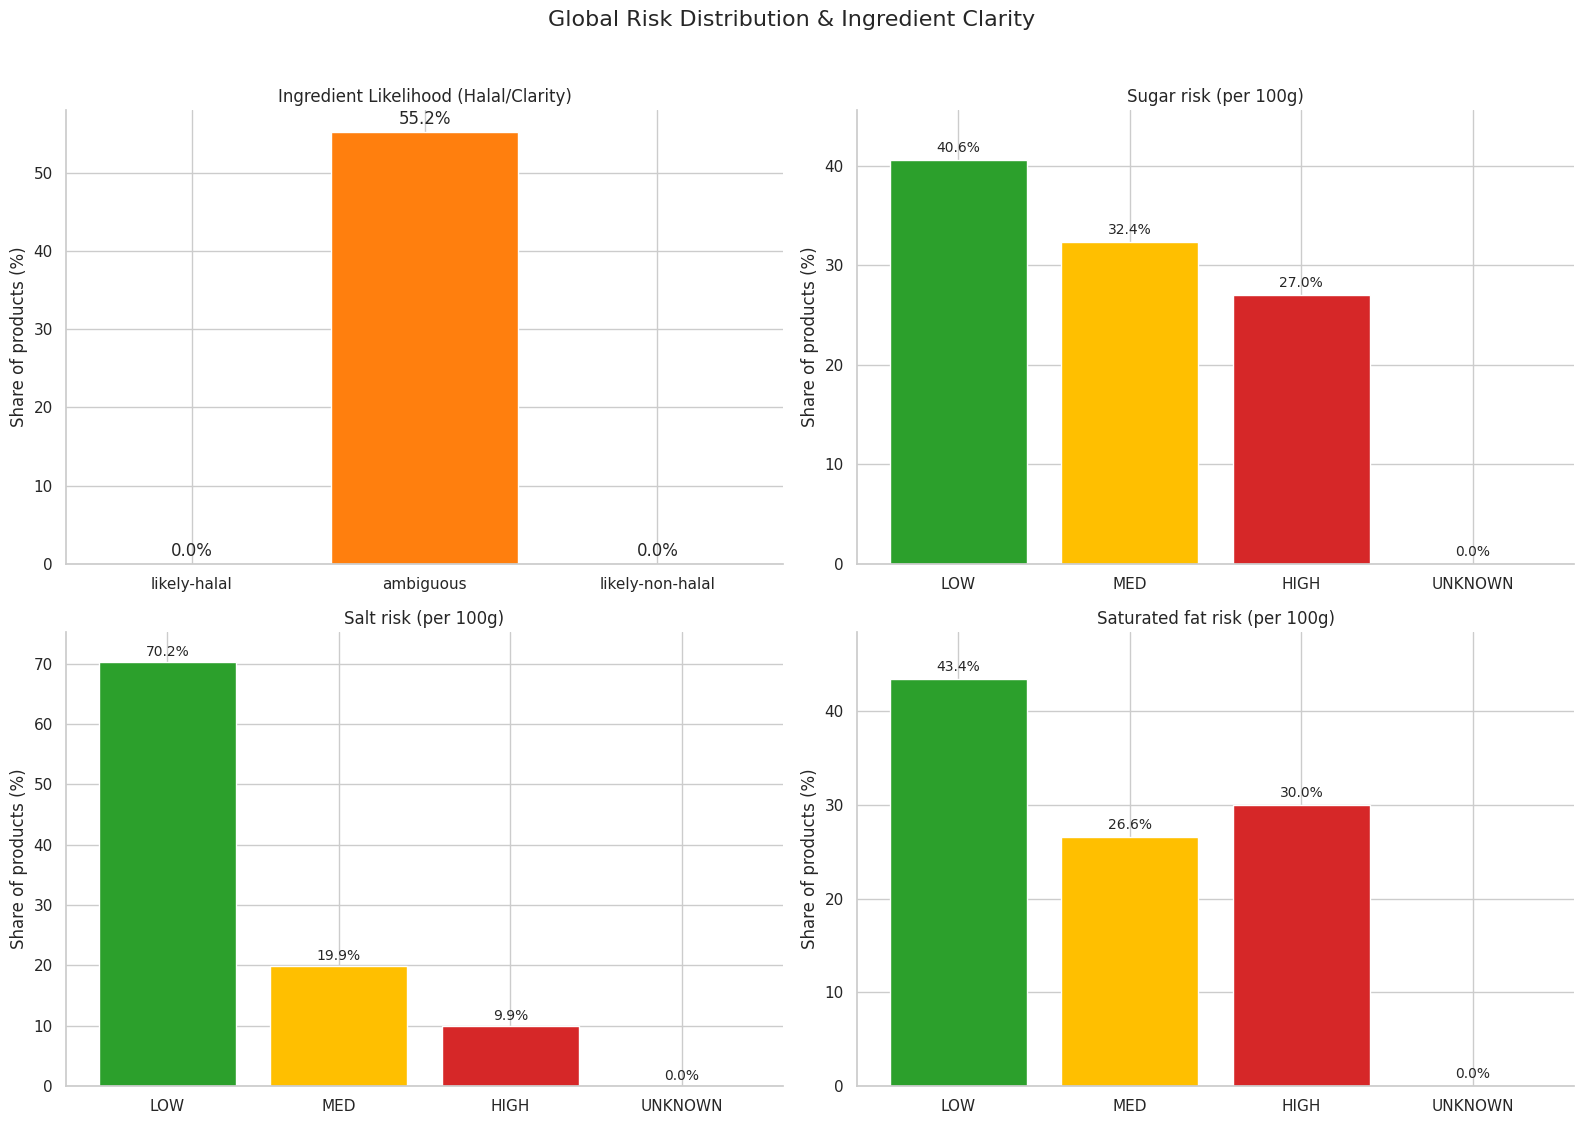

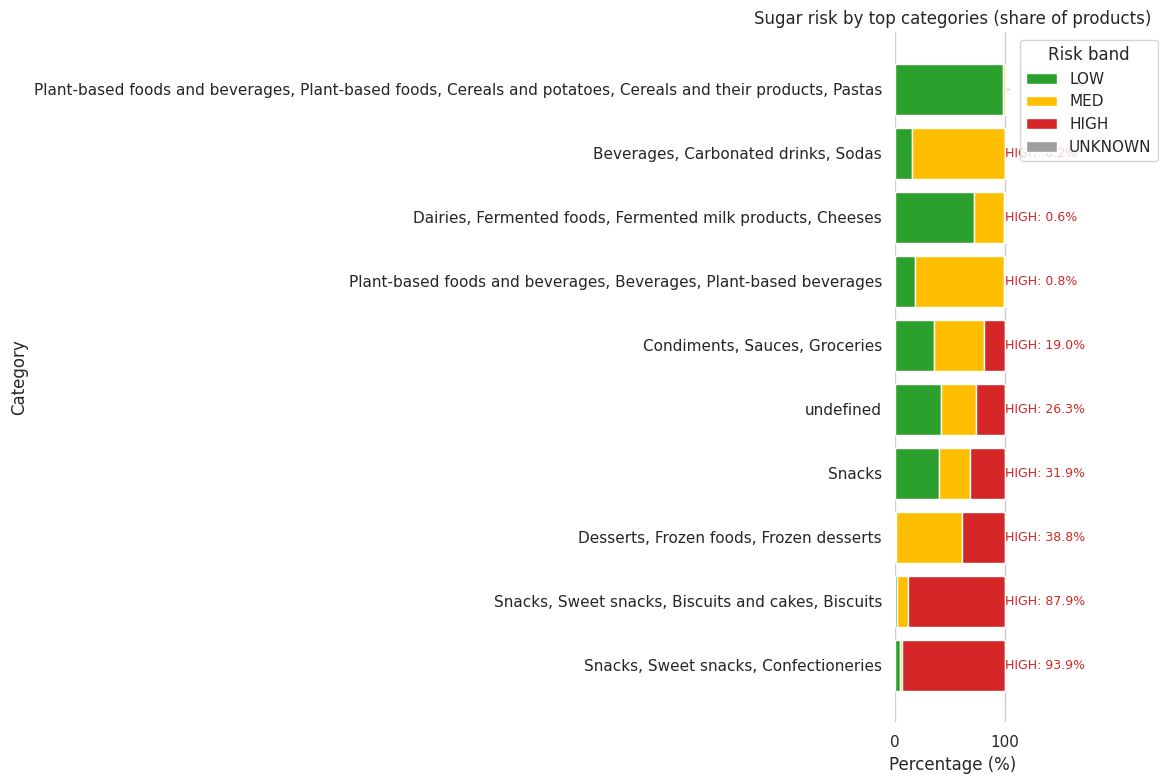

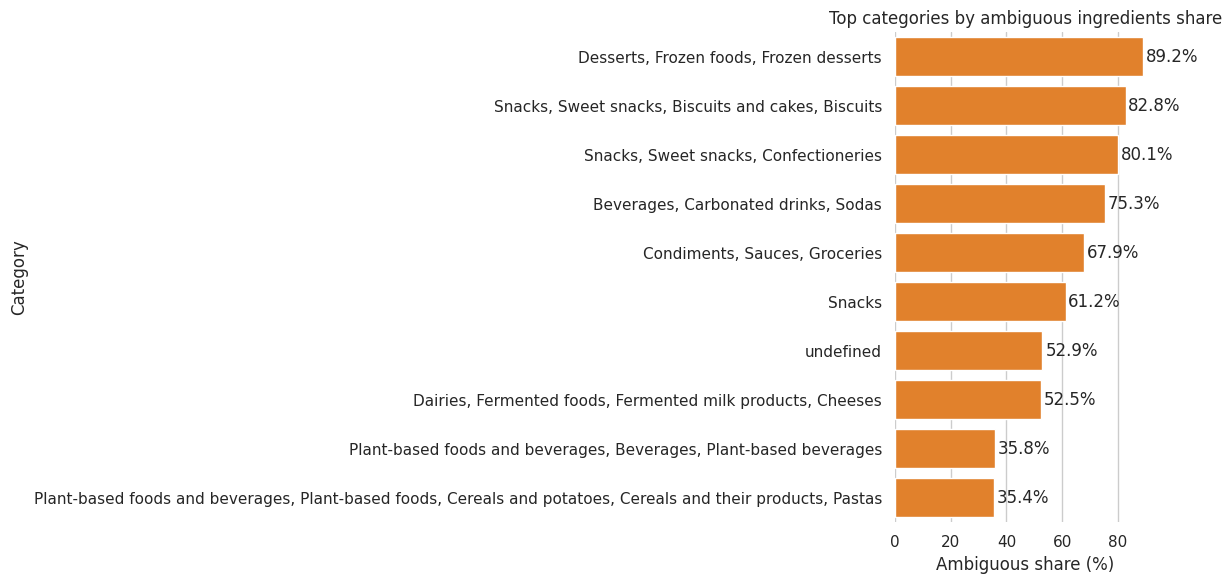

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===========================================
# 5. VISUALS — Konsisten, Mudah Dibaca, Insightful
# ===========================================

sns.set_theme(style="whitegrid")

# --- 5.0 Normalisasi nama & label band ---
# Mapper kolom versi lama -> baru
if "ingredient_status" in df_clean.columns and "halal_likelihood" not in df_clean.columns:
    df_clean["halal_likelihood"] = df_clean["ingredient_status"]

col_map = {
    "sugar_risk": "sugar_band",
    "salt_risk": "salt_band",
    "sat_fat_risk": "satfat_band",
}
for old, new in col_map.items():
    if old in df_clean.columns and new not in df_clean.columns:
        df_clean[new] = df_clean[old]

# Normalisasi nilai band (LOW/MED/HIGH/UNKNOWN)
def normalize_band(s):
    s = s.astype("string").str.upper().str.strip()
    s = s.replace({"MEDIUM":"MED", "MID":"MED", "MEDIUM ": "MED"})
    s = s.where(~s.isna(), "UNKNOWN")
    s = s.mask(~s.isin(["LOW","MED","HIGH","UNKNOWN"]), "UNKNOWN")
    return s

for col in ["sugar_band","salt_band","satfat_band"]:
    if col in df_clean.columns:
        df_clean[col] = normalize_band(df_clean[col])
    else:
        df_clean[col] = "UNKNOWN"

# palet traffic-light
palette_tl = {
    "LOW":   "#2ca02c",  # green
    "MED":   "#ffbf00",  # amber/yellow
    "HIGH":  "#d62728",  # red
    "UNKNOWN": "#9e9e9e" # grey
}

# =============================
# 5.1 Ringkas distribusi GLOBAL
# =============================

# Helper untuk plot batang proporsi global (1D)
def plot_global_band(ax, series, title):
    order = ["LOW","MED","HIGH","UNKNOWN"]
    pct = series.value_counts(normalize=True, dropna=False).reindex(order, fill_value=0).mul(100)
    bars = ax.bar(order, pct.values, color=[palette_tl[o] for o in order])
    ax.set_ylim(0, max(30, pct.max() + 5))
    ax.set_title(title)
    ax.set_ylabel("Share of products (%)")
    # label persentase di atas batang
    for b, v in zip(bars, pct.values):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)
    # make it tidy
    ax.spines[['top','right']].set_visible(False)

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Global Risk Distribution & Ingredient Clarity', fontsize=16, y=1.02)

# 5.1a Kejelasan/halal-likelihood (konteks bahan)
if "halal_likelihood" in df_clean.columns:
    order_hl = ["likely-halal","ambiguous","likely-non-halal"]
    vc = df_clean["halal_likelihood"].value_counts(normalize=True).reindex(order_hl, fill_value=0).mul(100)
    bars = axes[0,0].bar(order_hl, vc.values, color=["#2ca02c","#ff7f0e","#d62728"])
    axes[0,0].set_title("Ingredient Likelihood (Halal/Clarity)")
    axes[0,0].set_ylabel("Share of products (%)")
    for b, v in zip(bars, vc.values):
        axes[0,0].text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{v:.1f}%", ha="center", va="bottom")
    axes[0,0].spines[['top','right']].set_visible(False)
else:
    axes[0,0].axis("off")
    axes[0,0].text(0.5,0.5,"No halal_likelihood column", ha="center")

# 5.1b–d Global band untuk gula/garam/lemak jenuh
plot_global_band(axes[0,1], df_clean["sugar_band"],  "Sugar risk (per 100g)")
plot_global_band(axes[1,0], df_clean["salt_band"],   "Salt risk (per 100g)")
plot_global_band(axes[1,1], df_clean["satfat_band"], "Saturated fat risk (per 100g)")

plt.tight_layout()
plt.show()

# ==========================================================
# 5.2 Kategori dengan risiko GULA tertinggi (proporsi HIGH)
# ==========================================================
# Ambil 10 kategori teratas berdasarkan jumlah produk, lalu urutkan berdasarkan % HIGH sugar
top_categories = (
    df_clean["categories"]
      .value_counts()
      .head(10)
      .index
)
df_top = df_clean[df_clean["categories"].isin(top_categories)].copy()

# hitung proporsi band per kategori
sugar_tab = (
    df_top.groupby("categories")["sugar_band"]
          .value_counts(normalize=True)
          .mul(100)
          .unstack()
          .reindex(columns=["LOW","MED","HIGH","UNKNOWN"])
          .fillna(0)
)

# urutkan baris berdasarkan HIGH desc
sugar_tab = sugar_tab.sort_values(by="HIGH", ascending=False)

# stacked barh
fig, ax = plt.subplots(figsize=(12, 8))
left = np.zeros(len(sugar_tab))
for band in ["LOW","MED","HIGH","UNKNOWN"]:
    vals = sugar_tab[band].values
    ax.barh(sugar_tab.index, vals, left=left, color=palette_tl[band], label=band)
    left += vals

ax.set_title("Sugar risk by top categories (share of products)")
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Category")
ax.legend(title="Risk band", bbox_to_anchor=(1.02, 1), loc="upper left")
# anotasi proporsi HIGH di ujung bar untuk menonjolkan risiko
for y, v in enumerate(sugar_tab["HIGH"].values):
    if v > 0:
        ax.text(100.5, y, f"HIGH: {v:.1f}%", va="center", fontsize=9, color="#d62728")

ax.set_xlim(0, 105)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# ==========================================================
# 5.3 Kategori dengan bahan "ambiguous" tertinggi (opsional)
# ==========================================================
if "halal_likelihood" in df_clean.columns:
    ambig = (
        df_top.assign(is_ambiguous=(df_top["halal_likelihood"]=="ambiguous"))
              .groupby("categories")["is_ambiguous"]
              .mean().mul(100)
              .sort_values(ascending=False)
              .head(10)
    )
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=ambig.values, y=ambig.index, ax=ax, color="#ff7f0e")
    ax.set_title("Top categories by ambiguous ingredients share")
    ax.set_xlabel("Ambiguous share (%)")
    ax.set_ylabel("Category")
    # label nilai di ujung bar
    for y, v in enumerate(ambig.values):
        ax.text(v + 1, y, f"{v:.1f}%", va="center")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()


In [ ]:
# === 0) Helper: panggil Granite via Replicate (deterministik) ===
import replicate, json

MODEL_ID = "ibm-granite/granite-3.3-8b-instruct"

def granite_generate(prompt, max_tokens=300, temperature=0.0):
    """
    Panggil Granite via Replicate dan kembalikan string tunggal.
    """
    out = replicate.run(
        MODEL_ID,
        input={
            "prompt": prompt,
            "max_tokens": max_tokens,   # gunakan 'max_tokens' (bukan max_new_tokens)
            "temperature": temperature,
            "top_p": 1.0,
            "presence_penalty": 0.0,
            "frequency_penalty": 0.0,
            "stream": False
        }
    )
    return "".join(out).strip()


# === 1) Util: hitung distribusi aman (persentase) ===
import pandas as pd
import numpy as np

def pct_dist(series):
    if series is None or len(series) == 0:
        return {}
    s = series.value_counts(normalize=True, dropna=True).mul(100).round(1)
    return s.to_dict()

def safe_pct(val):
    try:
        return float(np.round(float(val), 1))
    except Exception:
        return None


# === 2) Summarizer berbasis kategori (grounded + JSON) ===
def summarize_category(df_cat: pd.DataFrame, category_name: str) -> dict:
    """
    Returns a dict with:
    {
      "summary": "...",
      "insights": ["...", "..."],
      "recommendations": {
          "for_producers": ["...", "..."],
          "for_consumers": ["...", "..."]
      },
      "expected_impact": ["...", "..."],
      "caveats": ["...", "..."]
    }
    """
    # Columns used (align with your pipeline)
    halal_col = "halal_likelihood"
    sugar_col = "sugar_band"
    salt_col  = "salt_band"
    satf_col  = "satfat_band"

    # Backward-compat: map old column names if present
    for col_old, col_new in [("ingredient_status", halal_col),
                             ("sugar_risk", sugar_col),
                             ("salt_risk",  salt_col)]:
        if col_old in df_cat.columns and col_new not in df_cat.columns:
            df_cat[col_new] = df_cat[col_old]

    total_products = int(len(df_cat))
    halal_dist = pct_dist(df_cat[halal_col]) if halal_col in df_cat else {}
    sugar_dist = pct_dist(df_cat[sugar_col]) if sugar_col in df_cat else {}
    salt_dist  = pct_dist(df_cat[salt_col])  if salt_col  in df_cat else {}
    satf_dist  = pct_dist(df_cat[satf_col])  if satf_col  in df_cat else {}

    evidence = {
        "category": category_name,
        "num_products": total_products,
        "halal_likelihood_pct": halal_dist,  # e.g., {"likely-halal": 82.5, "ambiguous": 10.2, ...}
        "sugar_band_pct": sugar_dist,        # e.g., {"HIGH": 61.0, "MED": 24.5, "LOW": 10.0}
        "salt_band_pct":  salt_dist,
        "satfat_band_pct": satf_dist
    }
    data_context = json.dumps(evidence, ensure_ascii=False)

    # --- English prompt (grounded + JSON-only) ---
    prompt = f"""
You are a senior data analyst. Your task is to write a concise, decision-ready brief for the product category below.
Use ONLY the numbers provided in the JSON under DATA. Do NOT invent any figures or claims.

REQUIRED OUTPUT FORMAT (JSON only):
{{
  "summary": "2–3 concise sentences mentioning the number of products and the main risk pattern (quote exact % values).",
  "insights": [
    "One sharp, data-driven insight using the given percentages (e.g., 'HIGH sugar accounts for 61.0%').",
    "A second insight (e.g., 'ambiguous ingredients exceed 5%' or 'HIGH salt > 30%')."
  ],
  "recommendations": {{
    "for_producers": [
      "One specific and realistic action (e.g., reduce sugar by 5–10% in top variants; clarify E471/E472 origin; improve labels).",
      "A second concrete action."
    ],
    "for_consumers": [
      "One practical shopping tip for this category (e.g., prefer LOW/MED sugar; check vegan/vegetarian tags).",
      "A second practical tip."
    ]
  }},
  "expected_impact": [
    "A concrete outcome if the recommendations are followed (e.g., lower share of HIGH sugar items).",
    "A second outcome."
  ],
  "caveats": [
    "A clear note on data limitations (e.g., missing nutrients for some products) or category coverage."
  ]
}}

DATA (JSON):
{data_context}

INSTRUCTIONS:
- Quote percentages exactly as provided in DATA and include the '%' symbol when writing sentences.
- If a distribution is empty or missing, say "limited data" instead of guessing.
- Be concise, factual, and professional. No marketing fluff.
- Output MUST be valid JSON only, with the exact keys shown. No extra keys, no Markdown, no explanations.
"""

    raw = granite_generate(prompt, max_tokens=380, temperature=0.0)

    # Parse JSON safely; fall back to plain text if needed
    try:
        out = json.loads(raw)
        out.setdefault("summary", "")
        out.setdefault("insights", [])
        out.setdefault("recommendations", {}).setdefault("for_producers", [])
        out["recommendations"].setdefault("for_consumers", [])
        out.setdefault("expected_impact", [])
        out.setdefault("caveats", [])
        return out
    except json.JSONDecodeError:
        return {
            "summary": raw,
            "insights": [],
            "recommendations": {"for_producers": [], "for_consumers": []},
            "expected_impact": [],
            "caveats": ["Model returned non-JSON text; needs manual cleanup."]
        }


# === 3) Contoh pemakaian (kategori teratas) ===
# Pastikan kamu sudah punya df_clean dan daftar top_categories (mis. dari plot sebelumnya)
if 'top_categories' in globals() and len(top_categories) > 0:
    category_to_analyze = top_categories[0]
else:
    # fallback: ambil kategori paling sering
    top_categories = df_clean['categories'].value_counts().index.tolist()
    category_to_analyze = top_categories[0] if top_categories else "Kategori Tidak Diketahui"

df_category = df_clean[df_clean['categories'] == category_to_analyze].copy()
print(f"Mempersiapkan ringkasan untuk kategori: '{category_to_analyze}'...")

summary_json = summarize_category(df_category, category_to_analyze)

print("\n=== 📄 RINGKASAN (JSON) ===")
print(json.dumps(summary_json, ensure_ascii=False, indent=2))

# (Opsional) Tampilkan versi human-readable
print("\n=== 🧭 RINGKASAN TERFORMAT ===")
print("Ringkasan:", summary_json.get("summary",""))
print("\nInsight:")
for it in summary_json.get("insights", []):
    print("-", it)
print("\nRekomendasi untuk Produsen:")
for it in summary_json.get("recommendations", {}).get("for_producers", []):
    print("-", it)
print("\nRekomendasi untuk Konsumen:")
for it in summary_json.get("recommendations", {}).get("for_consumers", []):
    print("-", it)
print("\nDampak yang Diharapkan:")
for it in summary_json.get("expected_impact", []):
    print("-", it)
print("\nCatatan/Batasan:")
for it in summary_json.get("caveats", []):
    print("-", it)


Mempersiapkan ringkasan untuk kategori: 'undefined'...

=== 📄 RINGKASAN (JSON) ===
{
  "summary": "Out of 27,191 products analyzed, 52.9% have ambiguous halal likelihood, and 26.3% fall into the high sugar category. High salt content is a concern for only 2.5% of products.",
  "insights": [
    "High sugar content is prevalent, accounting for 26.3% of the products.",
    "Despite limited data on other nutritional aspects, the high salt category is very small at 2.5%."
  ],
  "recommendations": {
    "for_producers": [
      "Address the ambiguity around halal likelihood by improving product labeling or conducting thorough ingredient audits for 46.8% of products.",
      "Given 26.3% of products fall into the high sugar category, consider reducing sugar content in formulations to meet consumer demand for lower sugar options."
    ],
    "for_consumers": [
      "When purchasing, prioritize products with low sugar content, which comprises 42.2% of the analyzed products.",
      "For thos